# SciPy solve_ivp example for 1<sup>st</sup> order ordinary differential equation

## Modelled system

We'll start with a simple ODE to demonstrate what the SciPy's solve_ivp function needs as arguments and what it outputs

The modelled system is a 1<sup>st</sup> order ODE

\begin{equation*}
    \frac{\mathrm{d}x}{\mathrm{d}t} = 2t
\end{equation*}

which has an analytical solution 

\begin{equation*}
    x(\mathrm{t}) = t^2 + C
\end{equation*}

With a condition that links x to certain time we can determine the constant C and solve the system precisely.

For example given x(t=0) = 3 we would get

\begin{align*}
    x(t\mathrm{=0}) &= 0^2 + C \\
    3 &= C \\
    C &= 3 
\end{align*}

We'll start familiriazing ourselves with solve_ivp by first solving this system with our own numerical method (explicit Euler's method) and then running solve_ivp and comparing the solutions we get. We'll use $x(t=0) = 3$ as our initial condition and solve the system in domain $t \in [0, 10]$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import ipywidgets as widgets
%matplotlib widget

### Euler's method

Euler's method is the simplest method to solve ODEs. The working principle of the method is to approximate the derivative $\frac{\mathrm{d}x}{\mathrm{d}t}$ with a discrete from  $\frac{\Delta x}{\Delta t}$

\begin{align*}
    \frac{\Delta x}{\Delta t} &= \frac{\mathrm{d}x}{\mathrm{d}t} \\
    \frac{x_{n+1}-x_{n}}{t_{n+1} - t_n} &= \frac{\mathrm{d}x}{\mathrm{d}t} \\
    x_{n+1}-x_{n} &= \frac{\mathrm{d}x}{\mathrm{d}t}(t_{n+1} - t_n) \\
    x_{n+1} &= x_n + \frac{\mathrm{d}x}{\mathrm{d}t}(t_{n+1} - t_n) \\
    x_{n+1} &= x_n  + f(x,t)h
\end{align*}
where $ h = (t_{n+1} - t_n) $ is the step size we want to take. In the last equation we have replaced $\frac{\mathrm{d}x}{\mathrm{d}t}$ with $f(x,t)$ which is the right hand side (RHS) function of the usual ODE specification $\frac{\mathrm{d}x}{\mathrm{d}t} = f(x,t)$

Let's create a function that implements the Euler's method for any given x(t=0),$ \frac{\mathrm{d}x}{\mathrm{d}t}$ and h

In [2]:
def euler(x0: float, dxdt: callable, h: float, t_end: float):
    t_start = 0
    N_points = int(t_end/h) + 1
    xt = np.zeros((N_points,))
    times = np.array([t_start+h*i for i in range(N_points)])
    xt[0] = x0
    for ind, t in enumerate(times[1:]):
        xt[ind+1] = dxdt(t)*h + xt[ind]

    return(times, xt)
    
odefun = lambda t: 2*t

solution = euler(3, odefun, h=1, t_end=10)
print(solution)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]), array([  3.,   5.,   9.,  15.,  23.,  33.,  45.,  59.,  75.,  93., 113.]))


### Visualize the Euler's method solution with h=1, h=0.1, h=0.01 and exact solution

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
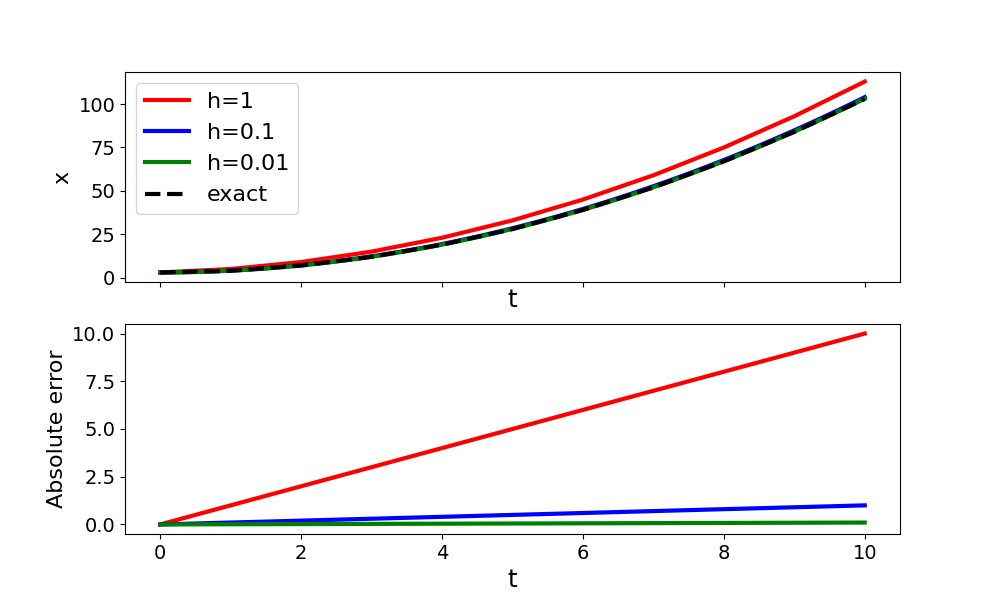

In [3]:
sol1 = euler(3, odefun, h=1, t_end=10)
sol2 = euler(3, odefun, h=0.1, t_end=10)
sol3 = euler(3, odefun, h=0.01, t_end=10)
exact_t = np.array([t for t in range(11)])
exact_x = [t**2+3 for t in range(11)]

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,6), sharex=True)

sols = [sol1, sol2, sol3, (exact_t, exact_x)]

colors = ['r','b','g','k']
linestyles = ['-','-','-','--']
labels = ['h=1', 'h=0.1','h=0.01', 'exact']
for i,s in enumerate(sols):
    ax[0].plot(s[0], s[1], color=colors[i], linestyle=linestyles[i], label=labels[i], linewidth=3)
    if i < 3:
        exact = np.array([t**2+3 for t in np.linspace(0,10, num=s[0].shape[0])])
        ax[1].plot(s[0], s[1]-exact, '-', color=colors[i], linewidth=3)
ax[0].legend(loc='upper left', fontsize=16)
ax[0].set_ylabel('x', fontsize=16)
ax[1].set_ylabel('Absolute error', fontsize=16)
for a in ax:
    a.tick_params(axis='both', labelsize=14)
    a.set_xlabel('t', fontsize=18)



## Solve system using SciPy's solve_ivp

[solve_ivp](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html) solves initial value ODE problems of the form

\begin{align*}
    \frac{\mathrm{d}x}{\mathrm{d}t} &= f(x,t) \\
    f(x,t_0) &= x_0
\end{align*}

Solve_ivp takes three mandatory arguments
```python
solve_ivp(fun(t,x), t_span, x0)
```
where ```fun(t,x)``` is a function that returns the value of right hand side (RHS) of the ODE ($f(x,t)$ above), ```t_span``` is a 2-tuple of floats specifying the start and end time of the solution e.g. ```t_span = (0, 10)``` solves from 0 to 10 in the time units specified by $f(x,t)$. ```x0``` is the initial state (initial value) of the system at the start time given as numpy array.

Note that the RHS function ```fun(t,x)``` takes two arguments the time t and array x even if your ```fun(t,x)``` does not use ```t``` or ```x``` these needs to be given as an input. ```fun(t,x)``` must return an array that has the same shape as ```x``` (and ```x0```, although we'll break this rule in notebook 5 when we talk about vectorization).

In practice if your RHS function does not need both ```t``` and ```x```, a convienient way to define ```fun(t,x)``` is to first define a normal python function that takes only the input you need and then speficy ```fun(x,t)``` as a lambda function

```python
def odefun(x):
    code here
    return x

solve_ivp(lambda t,x: odefun(x), t_span, x0)
```

In [4]:
def odefun(t):
    return 2*t

sol = solve_ivp(lambda t,x : odefun(t), (0, 10), [3])

print(sol)

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 38
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([0.0000e+00, 1.0000e-04, 1.1000e-03, 1.1100e-02, 1.1110e-01,
       1.1111e+00, 1.0000e+01])
 t_events: None
        y: array([[  3.        ,   3.00000001,   3.00000121,   3.00012321,
          3.01234321,   4.23454321, 103.        ]])
 y_events: None


### Solve_ivp additional argument ```t_eval```

Solve_ivp can take many additional arguments. One of the most useful is the ```t_eval``` argument. Adding ```t_eval``` to the solve_ivp call returns a solution to the ODE problem at the time specified by ```t_eval```.

In [5]:
odefun = lambda t: 2.0*t

sol = solve_ivp(lambda t,x : odefun(t), (0, 10), [3], t_eval = np.arange(0,11))

print(sol)

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 38
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])
 t_events: None
        y: array([[  3.,   4.,   7.,  12.,  19.,  28.,  39.,  52.,  67.,  84., 103.]])
 y_events: None


## Visualize the solution obtained from Euler's method, solve_ivp and exact calculation

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
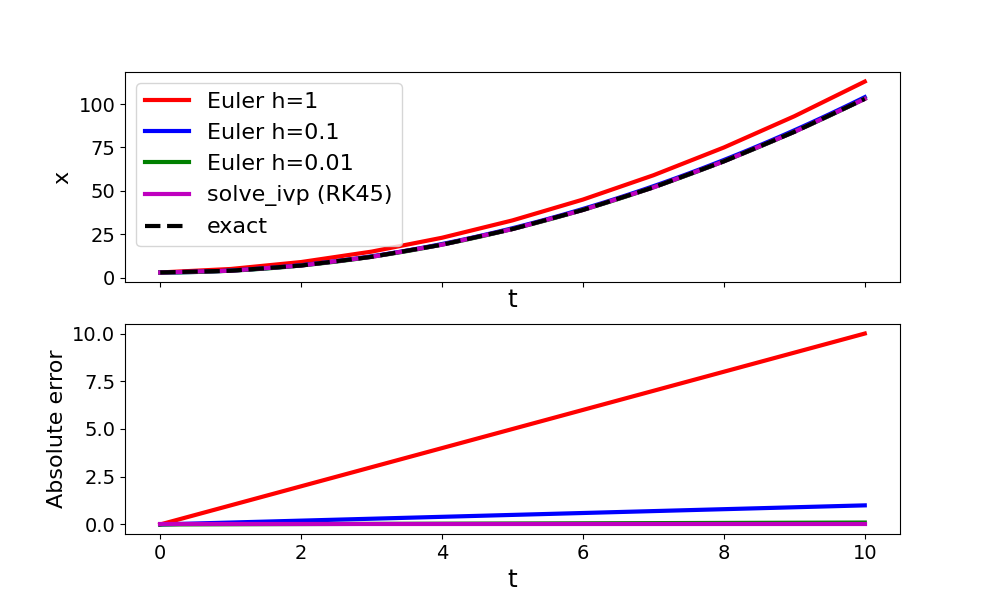

In [7]:
sol1 = euler(3, odefun, h=1, t_end=10)
sol2 = euler(3, odefun, h=0.1, t_end=10)
sol3 = euler(3, odefun, h=0.01, t_end=10)
exact_t = np.array([t for t in range(11)])
exact_x = [t**2+3 for t in range(11)]

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 6), sharex=True)

sols = [sol1, sol2, sol3, (sol.t, sol.y.reshape(sol.y.shape[1],)), (exact_t, exact_x)]

colors = ['r', 'b', 'g', 'm', 'k']
linestyles = ['-', '-', '-', '-', '--']
labels = ['Euler h=1', 'Euler h=0.1', 'Euler h=0.01', 'solve_ivp (RK45)', 'exact']
for i, s in enumerate(sols):
    ax[0].plot(s[0], s[1], color=colors[i], linestyle=linestyles[i], label=labels[i], linewidth=3)
    if i < 4:
        exact = np.array([t**2+3 for t in np.linspace(0, 10, num=s[0].shape[0])])
        ax[1].plot(s[0], s[1]-exact, '-', color=colors[i], linewidth=3)
ax[0].legend(loc='upper left', fontsize=16)
ax[0].set_ylabel('x', fontsize=16)
ax[1].set_ylabel('Absolute error', fontsize=16)
for a in ax:
    a.tick_params(axis='both', labelsize=14)
    a.set_xlabel('t', fontsize=18)
